<a href="https://colab.research.google.com/github/ConanOReilly/Final_Year_Project/blob/main/Multi_Modal_Predictions/MAFSwinTinyFocalLossISIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Swin-Tiny Modality Attention Fusion with Focal Loss Trained on ISIC 2019**

To test the valididaty of the results from the proposed method, the Swin-Tiny MAF model will be trained on the ISIC 2019 dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Libraries**

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import Swinv2Model
from torchvision import transforms
from PIL import Image, UnidentifiedImageError
import os
import pandas as pd
import random
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# **Importing ISIC 2019**

In [ ]:
! pip install kaggle

In [ ]:
# Remove the file if it exists and is not a directory
if os.path.exists("/root/.kaggle") and not os.path.isdir("/root/.kaggle"):
    os.remove("/root/.kaggle")

# Create the directory
os.makedirs("/root/.kaggle", exist_ok=True)

In [ ]:
!cp /content/drive/MyDrive/Final\ Year\ Project/Data/Kaggle\ API/kaggle.json /root/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/isic-2019 -p /content --unzip

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/isic-2019
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)


# **Defining Dataset, Classes, Weights, and Focal Loss**

In [ ]:
# Dataset
class ISIC2019Dataset(Dataset):
    def __init__(self, dataframe, img_dir, augment=True):
        self.df = dataframe.copy()
        self.img_dir = img_dir
        self.augment = augment

        # Ensure img_id column is present
        if 'img_id' not in self.df.columns:
            raise ValueError("The dataframe must contain an 'img_id' column for image filenames.")

        # Label encoding
        if 'label_encoded' not in self.df.columns:
            label_dict = {label: idx for idx, label in enumerate(sorted(self.df['diagnostic'].unique()))}
            self.df['label_encoded'] = self.df['diagnostic'].map(label_dict)
            self.label_dict = label_dict
        else:
            self.label_dict = {label: idx for idx, label in enumerate(sorted(self.df['diagnostic'].unique()))}

        # Convert metadata to usable numeric values
        self.df['sex'] = self.df['sex'].map({'male': 0, 'female': 1}).fillna(0)
        self.df['localization'] = self.df['localization'].astype('category').cat.codes
        self.df['age'] = self.df['age'].fillna(0)

        # Metadata columns used for the metadata branch
        self.metadata_cols = ['age', 'sex', 'localization']

        # Image transforms
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomRotation(20),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.base_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

        print("ISIC2019 Dataset Initialised")
        print("Using metadata columns:", self.metadata_cols)
        print("Label dictionary:", self.label_dict)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        attempts = 0
        max_attempts = 100

        while attempts < max_attempts:
            try:
                row = self.df.iloc[idx]
                img_name = row['img_id']
                img_path = os.path.join(self.img_dir, img_name + ".jpg") if not img_name.endswith(".jpg") else os.path.join(self.img_dir, img_name)
                image = Image.open(img_path).convert("RGB")

                # Apply transforms
                image = self.transform(image) if self.augment else self.base_transform(image)

                # Extract metadata
                metadata = torch.tensor(row[self.metadata_cols].astype(float).values, dtype=torch.float32)

                # Label
                label = int(row['label_encoded'])

                return image, metadata, label

            except (FileNotFoundError, UnidentifiedImageError):
                attempts += 1
                idx = random.randint(0, len(self.df) - 1)

        raise Exception(f"Failed to load image after {max_attempts} attempts.")

In [ ]:
# Balanced sampling
def make_weights_for_balanced_classes(dataset):
    class_counts = dataset.df['label_encoded'].value_counts()
    num_samples = len(dataset)
    class_weights = {i: num_samples / class_counts[i] for i in range(len(class_counts))}
    weights = [class_weights[label] for label in dataset.df['label_encoded']]
    return weights

In [ ]:
class ModalityAttentionFusion(nn.Module):
    def __init__(self, dim_img, dim_meta):
        super(ModalityAttentionFusion, self).__init__()
        self.attn_layer = nn.Sequential(
            nn.Linear(dim_img + dim_meta, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, img_feat, meta_feat):
        combined = torch.cat([img_feat, meta_feat], dim=1)
        attn_weights = self.attn_layer(combined)

        # Split weights
        img_alpha = attn_weights[:, 0].unsqueeze(1)
        meta_alpha = attn_weights[:, 1].unsqueeze(1)

        # Weighted fusion
        fused = img_alpha * img_feat + meta_alpha * meta_feat
        return fused

In [ ]:
# Multi-modal model
class MultiModalSwinClassifier(nn.Module):
    def __init__(self, num_classes, metadata_dim):
        super(MultiModalSwinClassifier, self).__init__()

        self.image_model = Swinv2Model.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")

        self.image_fc = nn.Sequential(
            nn.Linear(self.image_model.config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.metadata_fc = nn.Sequential(
            nn.Linear(metadata_dim, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            nn.Dropout(0.3),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 128)
        )

        self.fusion = ModalityAttentionFusion(128, 128)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, image, metadata):
        image_features = self.image_model(image).pooler_output
        image_features = self.image_fc(image_features)

        metadata_features = self.metadata_fc(metadata)
        fused = self.fusion(image_features, metadata_features)

        return self.classifier(fused)

In [ ]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    loop = tqdm(train_loader, desc="Training", leave=False)
    for images, metadata, labels in loop:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, metadata)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(train_loader), correct / total


In [ ]:
# Evaluation function
def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    loop = tqdm(val_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for images, metadata, labels in loop:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            outputs = model(images, metadata)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(val_loader), correct / total, all_preds, all_labels

In [ ]:
# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# **Defining Model**

In [ ]:
# Load the files
meta_df = pd.read_csv("/content/ISIC_2019_Training_Metadata.csv")
gt_df = pd.read_csv("/content/ISIC_2019_Training_GroundTruth.csv")

# Filter out rows where no label is positive
gt_df = gt_df[gt_df.iloc[:, 1:].sum(axis=1) > 0]

# Merge on the 'image' column
merged_df = pd.merge(gt_df, meta_df, on='image', how='inner')

# Convert one-hot encoded diagnosis columns into a single label
merged_df['diagnostic'] = merged_df.iloc[:, 1:10].idxmax(axis=1)

# Rename image column
merged_df['img_id'] = merged_df['image']

# Rename metadata columns
merged_df.rename(columns={
    'age_approx': 'age',
    'anatom_site_general': 'localization'
}, inplace=True)

# Preview result
print(merged_df[['img_id', 'diagnostic', 'age', 'sex', 'localization']].head())

# Save dataset
merged_df.to_csv("/content/isic2019_merged_metadata.csv", index=False)

         img_id diagnostic   age     sex     localization
0  ISIC_0000000         NV  55.0  female   anterior torso
1  ISIC_0000001         NV  30.0  female   anterior torso
2  ISIC_0000002        MEL  60.0  female  upper extremity
3  ISIC_0000003         NV  30.0    male  upper extremity
4  ISIC_0000004        MEL  80.0    male  posterior torso


In [ ]:
train_csv = "/content/isic2019_merged_metadata.csv"
img_dir = "/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input"

In [ ]:
# Encode the 'diagnostic' column
le = LabelEncoder()
merged_df['label_encoded'] = le.fit_transform(merged_df['diagnostic'])

In [ ]:
train_df, test_df = train_test_split(merged_df, test_size=0.2, stratify=merged_df['label_encoded'], random_state=42)

In [ ]:
metadata_cols = ['age', 'sex', 'localization']

In [ ]:
# Convert categorical metadata to numeric
train_df['sex'] = train_df['sex'].map({'male': 0, 'female': 1}).fillna(0)
test_df['sex'] = test_df['sex'].map({'male': 0, 'female': 1}).fillna(0)

train_df['localization'] = train_df['localization'].astype('category').cat.codes
test_df['localization'] = test_df['localization'].astype('category').cat.codes

train_df['age'] = train_df['age'].fillna(0)
test_df['age'] = test_df['age'].fillna(0)

In [ ]:
# StandardScaler
scaler = StandardScaler()
train_df[metadata_cols] = scaler.fit_transform(train_df[metadata_cols])
test_df[metadata_cols] = scaler.transform(test_df[metadata_cols])

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Datasets and Loaders
train_ds = ISIC2019Dataset(train_df, img_dir)
test_ds = ISIC2019Dataset(test_df, img_dir, augment=False)

ISIC2019 Dataset Initialised
Using metadata columns: ['age', 'sex', 'localization']
Label dictionary: {'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}
ISIC2019 Dataset Initialised
Using metadata columns: ['age', 'sex', 'localization']
Label dictionary: {'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}


In [ ]:
weights = make_weights_for_balanced_classes(train_ds)
sampler = WeightedRandomSampler(weights, len(weights))

In [ ]:
train_loader = DataLoader(train_ds, batch_size=12, sampler=sampler)
test_loader = DataLoader(test_ds, batch_size=12)

In [ ]:
# Model
model = MultiModalSwinClassifier(
    num_classes=len(train_ds.label_dict),
    metadata_dim=len(train_ds.metadata_cols)
).to(device)

In [ ]:
print("Label Dictionary:", train_ds.label_dict)

Label Dictionary: {'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}


In [ ]:
# View count of each class
class_counts = train_df['label_encoded'].value_counts().sort_index()
label_names = train_df.groupby('label_encoded')['diagnostic'].first()

print("Class Counts:\n", class_counts)
print("\nLabel Index to Class Name Mapping:\n", label_names)

Class Counts:
 label_encoded
0      694
1     2658
2     2099
3      191
4     3618
5    10300
6      502
7      202
Name: count, dtype: int64

Label Index to Class Name Mapping:
 label_encoded
0      AK
1     BCC
2     BKL
3      DF
4     MEL
5      NV
6     SCC
7    VASC
Name: diagnostic, dtype: object


In [ ]:
alpha = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0]).to(device)

In [ ]:
# Training setup
criterion = FocalLoss(alpha=alpha, gamma=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

epochs = 25
patience = 10
best_val_acc = 0.0
epochs_no_improve = 0

# Track metrics
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

lrs = []

# **Training Model**

In [ ]:
save_path = "/content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/isic2019_best_model.pth"

In [ ]:
# Training loop
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = evaluate(model, test_loader, criterion, device)

    # Logging
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    lrs.append(optimizer.param_groups[0]['lr'])

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    scheduler.step(val_acc)

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), save_path)
        print(f"Saved best model to {save_path}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Epoch 01 | Train Loss: 0.7807 | Val Loss: 0.6257 | Train Acc: 0.5905 | Val Acc: 0.5171
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/isic2019_best_model.pth


Epoch 02 | Train Loss: 0.4167 | Val Loss: 0.4293 | Train Acc: 0.7448 | Val Acc: 0.6767
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/isic2019_best_model.pth


Epoch 03 | Train Loss: 0.3132 | Val Loss: 0.3682 | Train Acc: 0.7931 | Val Acc: 0.7312
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/isic2019_best_model.pth


Epoch 04 | Train Loss: 0.2495 | Val Loss: 0.3948 | Train Acc: 0.8311 | Val Acc: 0.7099


Epoch 05 | Train Loss: 0.2070 | Val Loss: 0.4229 | Train Acc: 0.8506 | Val Acc: 0.7091


Epoch 06 | Train Loss: 0.1931 | Val Loss: 0.3281 | Train Acc: 0.8576 | Val Acc: 0.7482
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/isic2019_best_model.pth


Epoch 07 | Train Loss: 0.1595 | Val Loss: 0.3218 | Train Acc: 0.8727 | Val Acc: 0.7713
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/isic2019_best_model.pth


Epoch 08 | Train Loss: 0.1488 | Val Loss: 0.3099 | Train Acc: 0.8819 | Val Acc: 0.7758
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/isic2019_best_model.pth


Epoch 09 | Train Loss: 0.1367 | Val Loss: 0.3327 | Train Acc: 0.8878 | Val Acc: 0.7401


Epoch 10 | Train Loss: 0.1248 | Val Loss: 0.2824 | Train Acc: 0.8953 | Val Acc: 0.8007
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/isic2019_best_model.pth


Epoch 11 | Train Loss: 0.1212 | Val Loss: 0.2826 | Train Acc: 0.8970 | Val Acc: 0.8076
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/isic2019_best_model.pth


Epoch 12 | Train Loss: 0.1083 | Val Loss: 0.2972 | Train Acc: 0.9043 | Val Acc: 0.7874


Epoch 13 | Train Loss: 0.1068 | Val Loss: 0.3046 | Train Acc: 0.9056 | Val Acc: 0.7794


Epoch 14 | Train Loss: 0.0973 | Val Loss: 0.2947 | Train Acc: 0.9137 | Val Acc: 0.8216
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/isic2019_best_model.pth


Epoch 15 | Train Loss: 0.0968 | Val Loss: 0.3076 | Train Acc: 0.9131 | Val Acc: 0.7671


Epoch 16 | Train Loss: 0.0901 | Val Loss: 0.3221 | Train Acc: 0.9182 | Val Acc: 0.7869


Epoch 17 | Train Loss: 0.0893 | Val Loss: 0.2904 | Train Acc: 0.9209 | Val Acc: 0.8068


Epoch 18 | Train Loss: 0.0505 | Val Loss: 0.2619 | Train Acc: 0.9476 | Val Acc: 0.8309
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/isic2019_best_model.pth


Epoch 19 | Train Loss: 0.0472 | Val Loss: 0.2821 | Train Acc: 0.9478 | Val Acc: 0.8368
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/isic2019_best_model.pth


Epoch 20 | Train Loss: 0.0392 | Val Loss: 0.2562 | Train Acc: 0.9566 | Val Acc: 0.8502
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/isic2019_best_model.pth


Epoch 21 | Train Loss: 0.0378 | Val Loss: 0.2686 | Train Acc: 0.9591 | Val Acc: 0.8504
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/isic2019_best_model.pth


Epoch 22 | Train Loss: 0.0396 | Val Loss: 0.2596 | Train Acc: 0.9592 | Val Acc: 0.8476


Epoch 23 | Train Loss: 0.0345 | Val Loss: 0.2731 | Train Acc: 0.9630 | Val Acc: 0.8220


Epoch 24 | Train Loss: 0.0337 | Val Loss: 0.2640 | Train Acc: 0.9626 | Val Acc: 0.8362


Epoch 25 | Train Loss: 0.0222 | Val Loss: 0.2520 | Train Acc: 0.9723 | Val Acc: 0.8581
Saved best model to /content/drive/MyDrive/Final Year Project/Code/Hugging Face Models/WandB model/Model Paths/isic2019_best_model.pth


# **Evaluation**

In [ ]:
class_names = [label for label, idx in sorted(train_ds.label_dict.items(), key=lambda x: x[1])]

In [ ]:
# Load best model
model.load_state_dict(torch.load(save_path))
model.to(device)

val_loss, val_acc, val_preds, val_labels = evaluate(model, test_loader, criterion, device)


Classification Report:
               precision    recall  f1-score   support

          AK       0.79      0.75      0.77       173
         BCC       0.87      0.90      0.89       665
         BKL       0.84      0.76      0.80       525
          DF       0.91      0.85      0.88        48
         MEL       0.75      0.76      0.76       904
          NV       0.90      0.91      0.90      2575
         SCC       0.81      0.75      0.78       126
        VASC       0.92      0.96      0.94        51

    accuracy                           0.86      5067
   macro avg       0.85      0.83      0.84      5067
weighted avg       0.86      0.86      0.86      5067



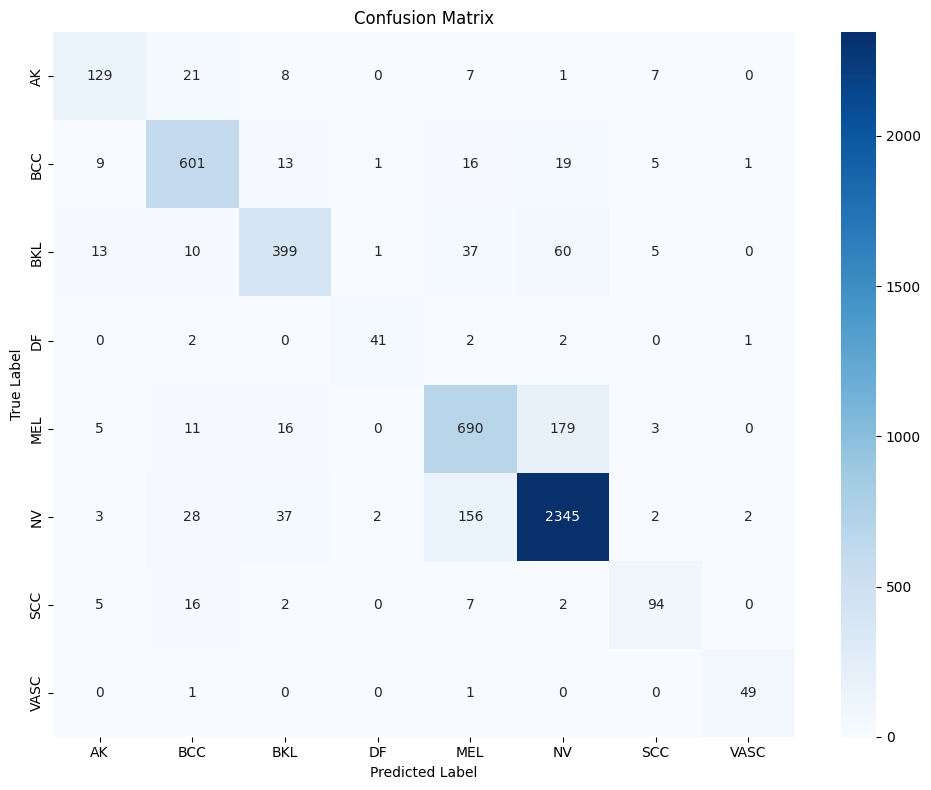

In [ ]:
val_preds = [int(p) for p in val_preds]
val_labels = [int(l) for l in val_labels]

# Classification report
report = classification_report(val_labels, val_preds, target_names=class_names)
print("\nClassification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()